In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


RAVDESS dataset
RAVDESS is one of the more common dataset used for this excercise by others. It's well liked because of its quality of speakers, recording and it has 24 actors of different genders. And there's more! You can get it in song format as well. There's something for everyone and their research project. So for convenience, here's the filename identifiers as per the official RAVDESS website:

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = - fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4

This means the meta data for the audio file is:

- Video-only (02)
- Speech (01)
- Fearful (06)
- Normal intensity (01)
- Statement "dogs" (02)
- 1st Repetition (01)
- 12th Actor (12) - Female (as the actor ID number is even)

At my early beginings embarking on this journey, I learnt through the hard way that male and female speakers have to be trained seperately or the model will struggle to get a good accuracy. From reading a few blogs and articles, it seems female has a higher pitch that male. So if we don't tag the gender label to the audio file, it won't be able to detect anger or fear if it was a male speaker. It will just get bucketed into neutral

Lets specifically model the 2 speakers seperately. Note that there's a 'calm' emotion and a 'neutral' emotion as seperate. I don't really know the difference but for now, I'll just combined them into the same category.

We are going to need some packages and libraries:

1)Numpy-for linear algebraic operations.

2)Scikit-learn-includes many statistical models.

3)Librosa-to extracts audio features.

4)Soundfile-to read and write sound files a well as to represent audio data as NumPy array.

Here, we are using Python language for programming. We are using the following libraries.

- Soundfile: Soundfile is a Python package to read the audio file of different formats, for example, WAV, FLAC, OGG, MAT files.
- Librosa:  Librosa is a Python package for audio and music analysis, for example, feature extraction and manipulation, segmentation, Visualization, and display.
- Os: Os is a Python package for using an operating system, for example, obtain the base name of a file, open the file in different modes like reading, write, append
- Glob: Glob is a Python package for finding path or pathnames of the file, the file having some specific pattern, For example, all files of.WAV extension.
- Pickle:  Pickle is a Python package for implements binary protocol. For example, serializing and de-serializing Python object structure.
- Numpy: Numpy is a Python package for scientific calculation, for example performing different operations on matrix.
- Sklearn: Sklearn is a Python package for performing different machine learning operations, for example predicting the unknown future values.

In [ ]:
#Import All Important Libraries
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files 
import librosa
import soundfile
import os, glob, pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

!pip install pydub
from pydub import AudioSegment

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras import optimizers, callbacks

In [ ]:
RAV = '/content/drive/MyDrive/Colab Notebooks/DATASETS/RAVDESS Dataset/'

In [ ]:
import os, glob

dir_list = os.listdir(RAV)
dir_list.sort()

In [ ]:
def extract_feature(file_name, mfcc, chroma, mel):
  with soundfile.SoundFile(file_name) as sound_file:
    X = sound_file.read(dtype="float32")
    sample_rate=sound_file.samplerate
    if chroma:
      stft=np.abs(librosa.stft(X))
    result=np.array([])
    if mfcc:
      mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
      result=np.hstack((result, mfccs))
    if chroma:
      chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
      result=np.hstack((result, chroma))
    if mel:
      mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
      result=np.hstack((result, mel))
  return result

In [ ]:
for folder in glob.glob(RAV+'/Actor_*'):
    for file in glob.glob(folder + '/*.wav'):
      sound = AudioSegment.from_wav(file) # Import an audio file
      sound = sound.set_channels(1)  ## This sets it to mono
      sound.export(file, format="wav")

In [ ]:
emotions = []
gender = []
features = []

for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
      part = f.split('.')[0].split('-')
      emotions.append(int(part[2]))
      temp = int(part[6])
      if temp % 2 == 0:
          temp = "female"
      else:
          temp = "male"
      gender.append(temp)
      features.append(extract_feature((RAV + i + '/' + f), mfcc = True, chroma = True, mel = True))

In [ ]:
RAV_df = pd.DataFrame(emotions)
RAV_df = RAV_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df_new = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df_new['labels'].value_counts()

In [ ]:
RAV_df

In [ ]:
sns.countplot(RAV_df.emotion)
plt.title('Emotion Count')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show();

Conclusion

...ok, to be fairly honest, I actual felt like that was a fearful tone at the start, up until the end. I had to play it 3 or 4 times to finally be convienced that it is indeed a happy sound. Looking at the wave plot between the 2 files, I notice the only real difference is the amplitute wherein this happy track has a higher amplituted at various points. But, could be coincidence, who knows at this stage.

What I do know is that the audio quality is good and we need females in the dataset. If we don't include females, we'll end up with an AI that is bias towards / aagainst one gender, and its unethical. Unless there's a good reason, I'm not taking it out.

### extracting useful features from audio for our classifier

Broadly speaking there are two category of features:

- Time domain features
  - These are simpler to extract and understand, like the energy of signal, zero crossing rate, maximum amplitude, minimum energy, etc.
- Frequency based features
  - are obtained by converting the time based signal into the frequency domain. Whilst they are harder to comprehend, it provides extra information that can be really handy such as pitch, rhythms, melody etc.

In [ ]:
RAV_df = pd.concat([RAV_df, pd.DataFrame(features)], axis=1)
RAV_df

In [ ]:
RAV_df.isnull().values.any()

In [ ]:
le = LabelEncoder()

RAV_df['emotion']= le.fit_transform(RAV_df['emotion'])

In [ ]:
X = RAV_df.drop(['gender', 'emotion', 'labels'], axis = 1)
y = RAV_df['emotion']

In [ ]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape)

In [ ]:
Model = Sequential()

Model.add(Dense(60, input_shape = (X_train.shape[1],), activation = 'relu', kernel_initializer = 'he_normal'))
Model.add(Dropout(0.3))
Model.add(BatchNormalization())
Model.add(Dense(80, activation = 'relu', kernel_initializer = 'he_normal'))
Model.add(Dropout(0.3))
Model.add(BatchNormalization())
Model.add(Dense(120, activation = 'relu', kernel_initializer = 'he_normal'))
Model.add(Dropout(0.3))
Model.add(BatchNormalization())
Model.add(Dense(70, activation = 'relu', kernel_initializer = 'he_normal'))
Model.add(Dropout(0.3))
Model.add(BatchNormalization())
Model.add(Dense(10, activation = 'softmax', kernel_initializer = 'he_normal'))

Model.summary()

In [ ]:
Model.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
              loss='sparse_categorical_crossentropy',     # Multiclass classification
              metrics=['accuracy'])

In [ ]:
earlyStopping = callbacks.EarlyStopping(monitor='loss', patience=5)

chkpnt_path = 'Model/Model_checkpoint'
modelCheckpoint = callbacks.ModelCheckpoint(
    filepath = chkpnt_path,
    save_weights_only = True,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True
)

In [ ]:
history = Model.fit(X_train, y_train, batch_size = 50, epochs = 100, verbose = 1, validation_split = 0.2, callbacks = [earlyStopping, modelCheckpoint])

In [ ]:
Model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 3ms/step - loss: 1.4641 - accuracy: 0.3924


[1.4640741348266602, 0.3923611044883728]

In [ ]:
def plot_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

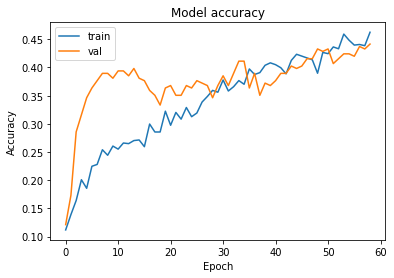

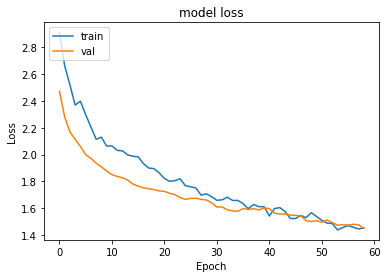

In [ ]:
plot_history(history)

Confusion Matrix: 



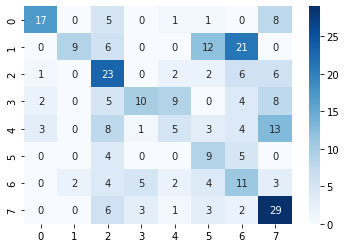

In [ ]:
y_pred = Model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print('Confusion Matrix: \n')
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.53      0.62        32
           1       0.82      0.19      0.31        48
           2       0.38      0.57      0.46        40
           3       0.53      0.26      0.35        38
           4       0.25      0.14      0.18        37
           5       0.26      0.50      0.35        18
           6       0.21      0.35      0.26        31
           7       0.43      0.66      0.52        44

    accuracy                           0.39       288
   macro avg       0.45      0.40      0.38       288
weighted avg       0.48      0.39      0.38       288

